In [24]:
import torch
import torch_geometric
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Data
from scipy.stats import ortho_group, special_ortho_group
from collections import Counter

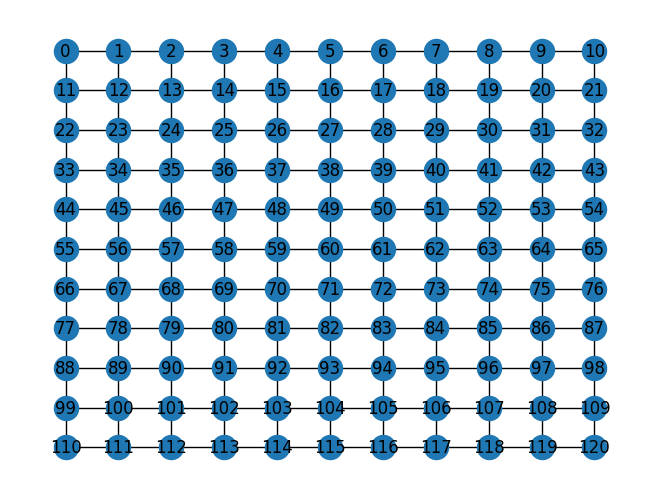

In [25]:
# create a 2D grid graph
k1 = 11
k2 = 11
grid = nx.grid_2d_graph(k1, k2)
n = k1 * k2
grid = nx.convert_node_labels_to_integers(grid)

# make grid undirected
grid = grid.to_undirected()
# add edges in the opposite direction
# grid.add_edges_from([(v, u) for (u, v) in grid.edges()])

# plot the graph
# create 2D coordinates
pos = dict()
for i in range(k1):
    for j in range(k2):
        pos[i * k2 + j] = (j, -i)

nx.draw(grid, pos=pos, with_labels=True)

C:\Users\guyle\AppData\Local\Temp\ipykernel_25244\1145248733.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("coolwarm")
C:\Users\guyle\AppData\Local\Temp\ipykernel_25244\1145248733.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


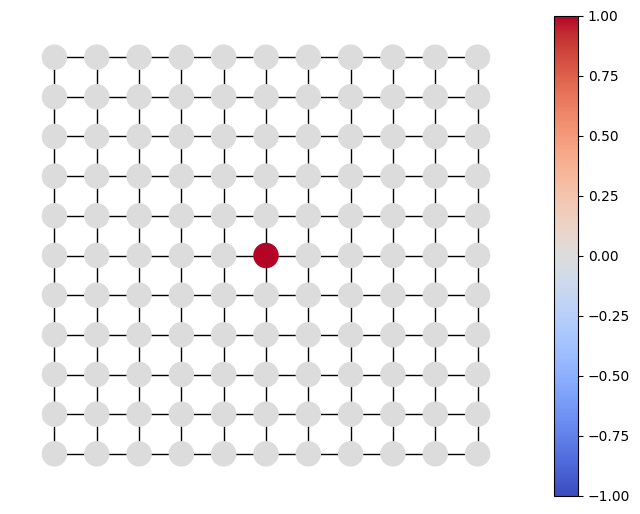

In [26]:
edges = list(grid.edges)
# add edges in the opposite direction
edges.extend([(v, u) for (u, v) in grid.edges()])
print(edges[:10])

edge_index = torch.tensor(edges).t().contiguous()
x = torch.tensor(np.zeros((n, 1)), dtype=torch.float)
# x will be a spike signal in the middle of the grid
x[(n - 1)//2] = 1
# x[42] = -1
data = Data(x=x, edge_index=edge_index)
data.validate(raise_on_error=True)

# create colormap that distinguishes between positive and negative values
cmap = plt.cm.get_cmap("coolwarm")

# node_color = [cmap(x) for x in data.x]

# visualize the spike signal
nx.draw(grid, pos=pos, node_color=data.x, cmap=cmap, with_labels=False, vmin=-1, vmax=1)
# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm)


## ChebConv spectral filter (isotropic)
### Using PyTorch Geometric

C:\Users\guyle\AppData\Local\Temp\ipykernel_25244\1775735775.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


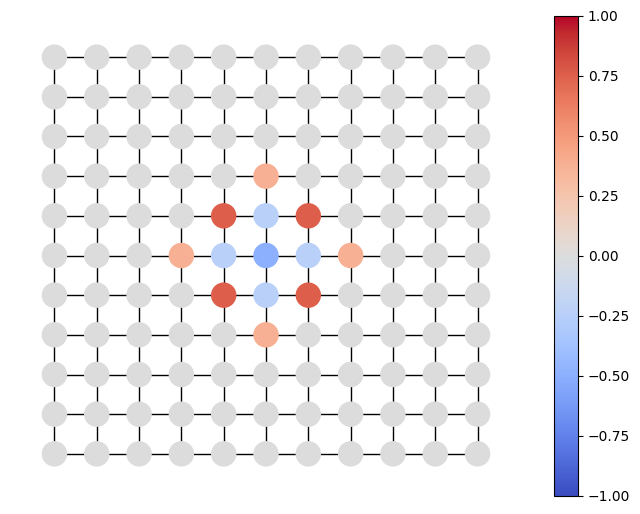

In [4]:
from torch_geometric.nn import ChebConv
# define a filter on a graph using pytorch geometric
class Filter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ChebConv(1, 1, K=4, bias=False, normalization='rw')

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return x
 
filter = Filter()
# set the filter weights
set_param_to = np.array([[1],[1],[3],[0]], dtype=np.float32)

for idx, param in enumerate(filter.conv1.parameters()):
    param.data = torch.tensor(set_param_to[idx])

# for param in filter.conv1.parameters():
#     print(param)

out = filter(data)

# visualize the output

nx.draw(grid, pos=pos, node_color=out.detach().numpy(), with_labels=False, cmap="coolwarm", vmin=-1, vmax=1)
# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm)
plt.show()


## Building the spectral filter explicitly
### Simple polynomial filter (isotropic)
$Cf = \mathcal{F}^* \mathcal{D}_{g(\Lambda)} \mathcal{F} f$

C:\Users\guyle\AppData\Local\Temp\ipykernel_25244\2361151475.py:18: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


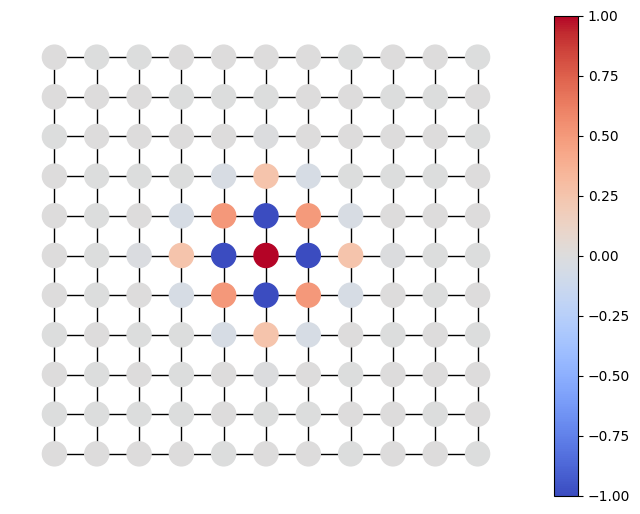

In [5]:
# explicit spectral graph filter
L = nx.normalized_laplacian_matrix(grid)
L = L.todense()
eigenvalues, eigenvectors = np.linalg.eigh(L)
x = torch.tensor(np.zeros((n, 1)), dtype=torch.float)
# x will be a spike signal in the middle of the grid
x[(n-1)//2] = 1
g = lambda x, a0, a1, a2, a3, a4: a0 + a1 * x + a2 * x**2 + a3 * x**3 + a4 * x**4
D = np.diag(g(eigenvalues, 1, 1, 1, 1, 0))
spectral_filter = eigenvectors @ D @ eigenvectors.T
output = spectral_filter @ x.numpy()
# visualize the output

nx.draw(grid, pos=pos, node_color=output, with_labels=False, cmap="coolwarm", vmin=-1, vmax=1)
# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-1, vmax=1))
sm.set_array([])
plt.colorbar(sm)
plt.show()

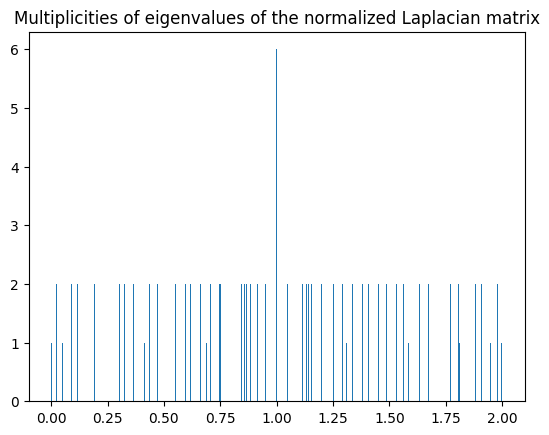

In [6]:
# plot histogram of eigenvalues
plt.hist(eigenvalues, bins=500)
plt.title('Multiplicities of eigenvalues of the normalized Laplacian matrix')
plt.show()

In [7]:
def construct_block_diagonal_ortho(eigenvalues, round_precision=3):
    eigenvalues_round = np.round(eigenvalues, round_precision)
    cntr = Counter(eigenvalues_round)
    
    n = len(eigenvalues)
    R = np.zeros((n, n))
    multiplicities = []
    next_start_from = 0

    for val in np.unique(eigenvalues_round):
        multiplicity = cntr[val]
        multiplicities.append(multiplicity)
        if multiplicity == 1:
            R[next_start_from, next_start_from] = 1
        else:
            R[next_start_from:next_start_from + multiplicity, next_start_from:next_start_from + multiplicity] = ortho_group.rvs(dim=multiplicity)

        next_start_from += multiplicity

    return R, np.array(multiplicities)

def shear_across_blocks(Q, multiplicities):
    n = len(multiplicities)
    R = np.zeros(Q.shape)
    start_from = 0
    for idx, multiplicity in enumerate(multiplicities):
        shear = np.zeros((multiplicity, multiplicity))
        shear[0,0] = 1
        # R[start_from:start_from + multiplicity, start_from:start_from + multiplicity] = scales[idx] * Q[start_from:start_from + multiplicity, start_from:start_from + multiplicity]
        R[start_from:start_from + multiplicity, start_from:start_from + multiplicity] = shear @ Q[start_from:start_from + multiplicity, start_from:start_from + multiplicity]
        start_from += multiplicity
    return R

In [8]:
a = np.array([1, 2, 2, 3])
Q, multiplicities = construct_block_diagonal_ortho(a)
print(multiplicities)
S = shear_across_blocks(Q, multiplicities)
print(Q)
print(S)

[1 2 1]
[[ 1.          0.          0.          0.        ]
 [ 0.         -0.34442284 -0.93881463  0.        ]
 [ 0.         -0.93881463  0.34442284  0.        ]
 [ 0.          0.          0.          1.        ]]
[[ 1.          0.          0.          0.        ]
 [ 0.         -0.34442284 -0.93881463  0.        ]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          1.        ]]


Option 1 - $VRDR^TV^Tf$

Option 2 - $VRV^TDVR^TV^Tf$

Isotropic function $g(\lambda)$

$\Lambda$

$(d_1, ..., d_n) \approx VRV^T$

$\sum_j c_j <f,e_j> e_j$

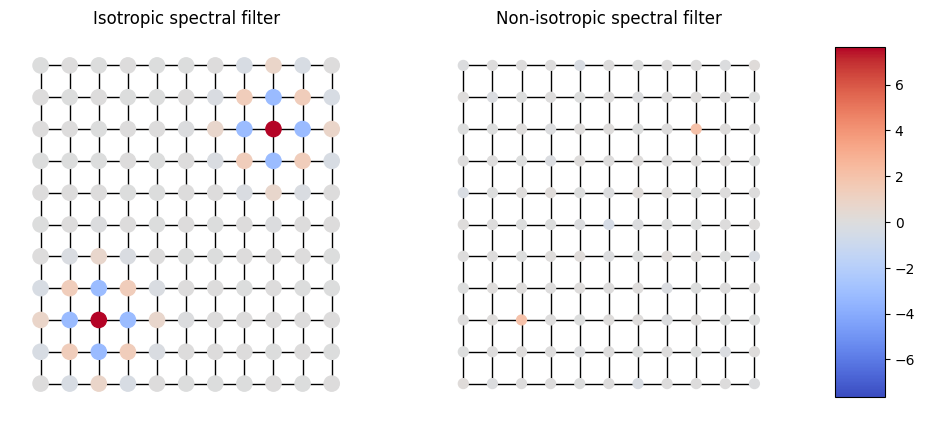

In [23]:
# np.random.seed(0)
# create a random orthogonal matrix
# Q = ortho_group.rvs(dim=n) # entirely random orthogonal matrix of size n
# Q, multiplicities = construct_block_diagonal_ortho(eigenvalues) # block diagonal orthogonal matrix of size n, blocks of size corresponding to eigenvalue multiplicities
D_iso = np.diag(g(eigenvalues, 1, 1, 1, 1, 1))
# Q_shear = shear_across_blocks(Q, multiplicities)
# random_zeroes_ones = np.diag(np.random.randint(0, 2, len(eigenvalues)))


omega = 0.5
func = lambda x: (np.sin(omega*x) + 2)
D_non_iso = np.diag(func(np.arange(len(eigenvalues)) + 1))
# D_non_iso = np.diag(np.random.normal(0, 1, len(eigenvalues))) * D_iso

Q, multiplicities = construct_block_diagonal_ortho(eigenvalues)

isotropic_spectral_filter = eigenvectors @ D_iso @ eigenvectors.T
non_isotropic_spectral_filter = eigenvectors @ Q @ D_non_iso @ Q.T @ eigenvectors.T # IS THE SAME AS ISOTROPIC WHEN Q IS CONSTRUCTED LIKE WE SUGGESTED
# non_isotropic_spectral_filter = eigenvectors @ D_non_iso @ eigenvectors.T

output_iso = isotropic_spectral_filter @ x.numpy()
mask_iso = np.abs(output_iso) > 0.2
output_non_iso = non_isotropic_spectral_filter @ x.numpy()
masked_output_non_iso = output_non_iso * mask_iso
# visualize the output

# print(np.min(output_iso), np.max(output_iso))
# print(np.min(masked_output_non_iso), np.max(masked_output_non_iso))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

bound = np.max([np.max(np.abs(output_iso)), np.max(np.abs(masked_output_non_iso))])

nx.draw(grid, pos=pos, node_color=output_iso, with_labels=False, cmap="coolwarm", vmin=-bound, vmax=bound, ax=ax[0], node_size=120)
ax[0].set_title('Isotropic spectral filter')
nx.draw(grid, pos=pos, node_color=output_non_iso, with_labels=False, cmap="coolwarm", vmin=-bound, vmax=bound, ax=ax[1], node_size=50)
ax[1].set_title('Non-isotropic spectral filter')

# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-bound, vmax=bound))
sm.set_array([])
# add a custom small axis for the colorbar
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(sm, cax=cbar_ax)
plt.show()

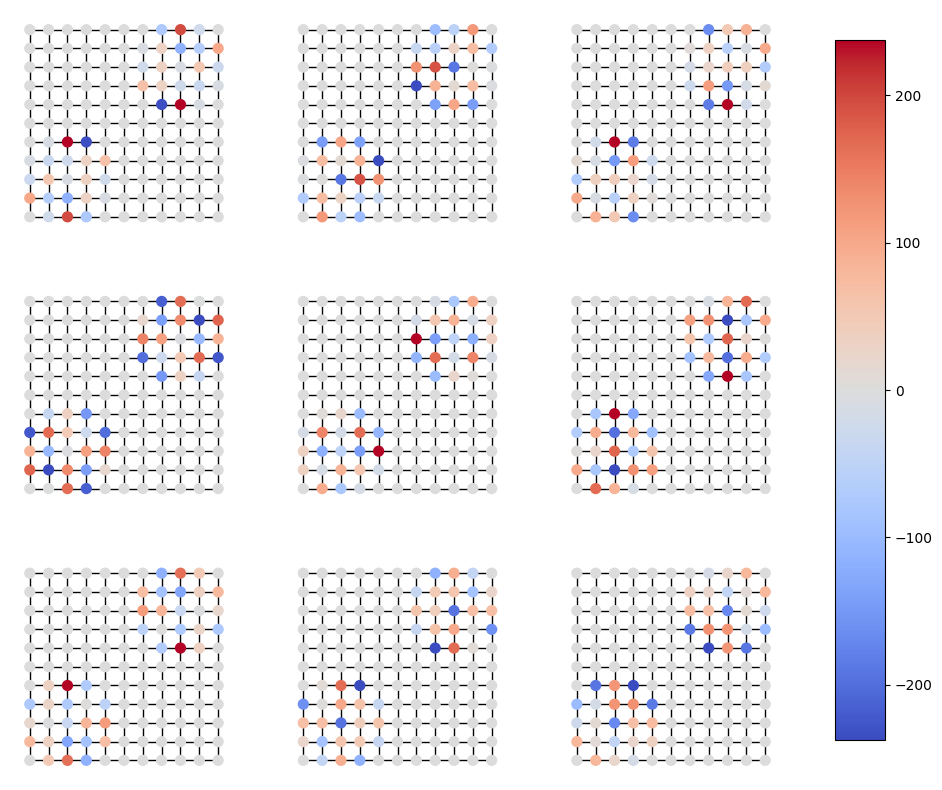

In [22]:
# np.random.seed(0)
# create a random orthogonal matrix
# Q = ortho_group.rvs(dim=n) # entirely random orthogonal matrix of size n
# Q, multiplicities = construct_block_diagonal_ortho(eigenvalues) # block diagonal orthogonal matrix of size n, blocks of size corresponding to eigenvalue multiplicities
D_iso = np.diag(g(eigenvalues, 1, 1, 1, 1, 1))
# Q_shear = shear_across_blocks(Q, multiplicities)
# random_zeroes_ones = np.diag(np.random.randint(0, 2, len(eigenvalues)))


omega = 0.5
func = lambda x: x*(np.sin(omega*x) + 2)
# D_non_iso = np.diag(func(np.arange(len(eigenvalues)) + 1))
D_non_iso = np.diag(np.random.normal(0, 200, len(eigenvalues))) * D_iso

x = torch.tensor(np.zeros((n, 1)), dtype=torch.float)
# x will be a spike signal in the middle of the grid
x[30] = 1
x[90] = 1


# num_Q = 9
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax in axes.flatten():
    Q, multiplicities = construct_block_diagonal_ortho(eigenvalues)

    isotropic_spectral_filter = eigenvectors @ D_iso @ eigenvectors.T
    non_isotropic_spectral_filter = eigenvectors @ Q @ D_non_iso @ Q.T @ eigenvectors.T # IS THE SAME AS ISOTROPIC WHEN Q IS CONSTRUCTED LIKE WE SUGGESTED
    # non_isotropic_spectral_filter = eigenvectors @ D_non_iso @ eigenvectors.T

    output_iso = isotropic_spectral_filter @ x.numpy()
    mask_iso = np.abs(output_iso) > 0.2
    output_non_iso = non_isotropic_spectral_filter @ x.numpy()
    masked_output_non_iso = output_non_iso * mask_iso
    # visualize the output

    # print(np.min(output_iso), np.max(output_iso))
    # print(np.min(masked_output_non_iso), np.max(masked_output_non_iso))

    # fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    bound = np.max([np.max(np.abs(output_iso)), np.max(np.abs(masked_output_non_iso))])

    # nx.draw(grid, pos=pos, node_color=output_iso, with_labels=False, cmap="coolwarm", vmin=-bound, vmax=bound, ax=ax[0], node_size=80)
    # ax[0].set_title('Isotropic spectral filter')
    nx.draw(grid, pos=pos, node_color=masked_output_non_iso, with_labels=False, cmap="coolwarm", vmin=-bound, vmax=bound, ax=ax, node_size=50)
    # ax.set_title('Non-isotropic spectral filter')

# colorbar
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=-bound, vmax=bound))
sm.set_array([])
# add a custom small axis for the colorbar
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(sm, cax=cbar_ax)
plt.show()

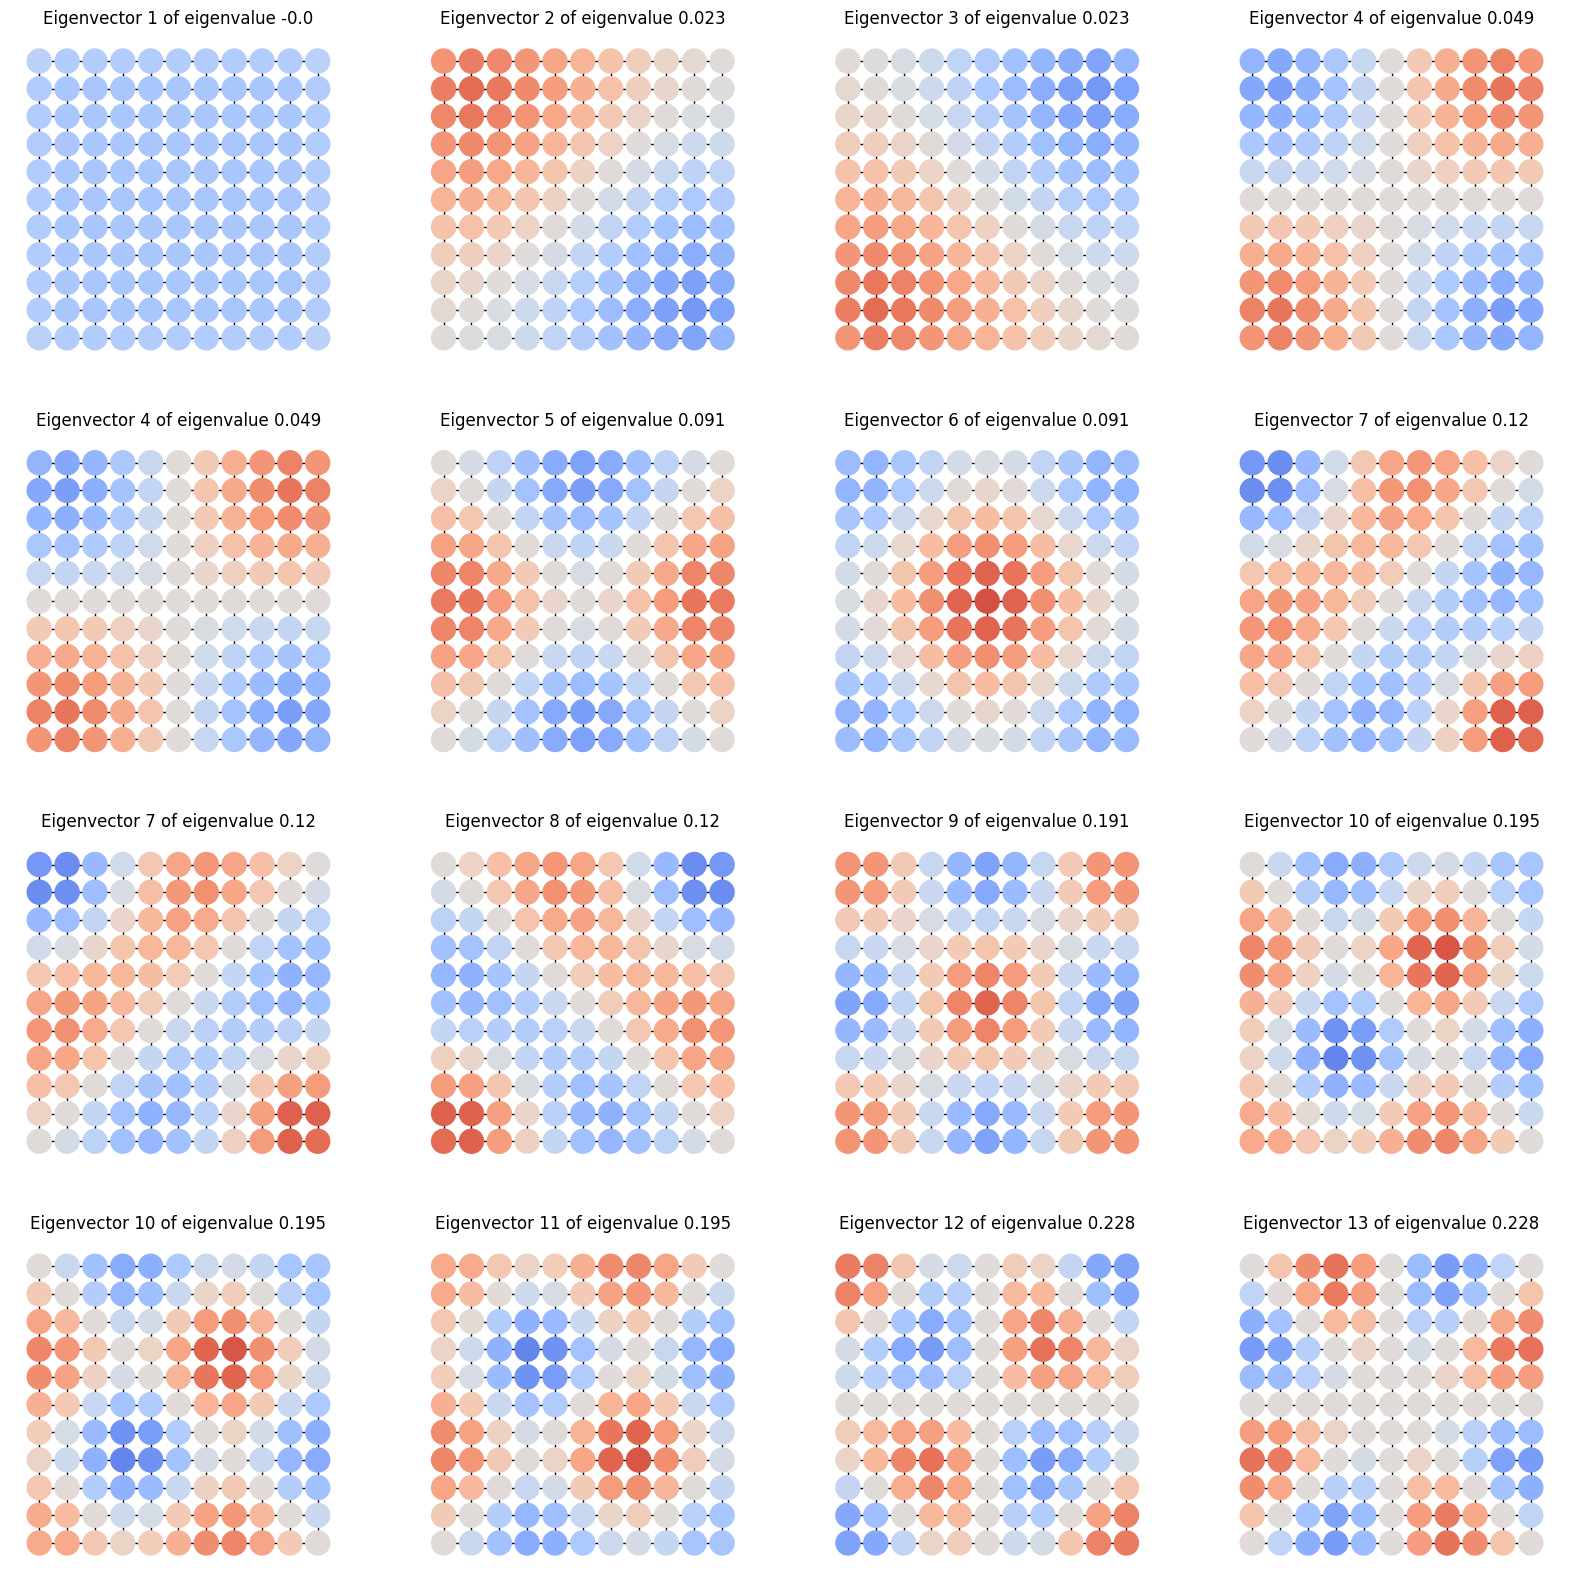

In [ ]:
# plot first N^2 eigenvectors
N = 4
fig, ax = plt.subplots(N, N, figsize=(20, 20))
for i in range(N):
    for j in range(N):
        nx.draw(grid, pos=pos, node_color=eigenvectors[:, i*3+j], with_labels=False, cmap="coolwarm", vmin=np.min(eigenvectors), vmax=np.max(eigenvectors), ax=ax[i, j])
        ax[i, j].set_title(f'Eigenvector {i*3+j+1} of eigenvalue {np.round(eigenvalues[i*3+j], 3)}')
plt.show()

implement contiunous Euclidean 2D grid and see the function that arises from the spectrum